# 4G10 Coursework 2: predicting hand kinematics from neural data


Please read carefully the last section of this notebook, which gives some of our expectations regarding your report.

In this handout, 
- <u>text that is underlined</u> corresponds to things you have to do / implement.
- **text in bold** corresponds to questions you need to answer in some form in your report.


In [1]:
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import r2_score, mean_squared_error
from scipy.signal import lfilter
import time

# 1. Setup

In this piece of 4G10 coursework, you will use neural data recorded in the primary motor cortex (M1) of a reaching monkey to predict the kinematics of the monkey's hand.

The monkey initiated each trial by placing their hand in the center of a fronto-parallel screen. A target then appeared on the screen. The monkey had to wait for a ‘go’ cue before making a reaching movement towards the instructed target. The targets were placed in various positions in a virtual maze, which changed in each trial, forcing the monkey to make a variety of reaching movements across trials.

The activity of $N=162$ motor cortical neurons was recorded simultaneously, alongside the kinematics of the animal's hand.

In the dataset presented below, all time series are partitioned into trials. Each trial begins at the go cue and lasts 800ms ($T = 16$ bins of 50ms duration) — roughly the duration of a reach. 

In [2]:
# grab the data from the server
r = requests.get('http://4G10.cbl-cambridge.org/data.npz', stream = True)
data = np.load(BytesIO(r.raw.read()))

Among other things (detailed later), this dictionary numerical arrays indexed by the following keys:
- `"hand_train" (2 × 400 × T)`: 2D velocity (X/Y) of the monkey's hand in 400 ‘train’ trials;
- `"neural_train" (N × 400 × T)`: neural activity (spike counts) in the same 400 ‘train’ trials;
- `"neural_test" (N × 100 × T)`: neural activity (spike counts) in 100 ‘test’ trials.

E.g.:

In [3]:
hand_train = data["hand_train"]
hand_train.shape

neural_train = data["neural_train"]
neural_train.shape

neural_test = data["neural_test"]
neural_test.shape

(162, 100, 16)

The goal of this CW is to implement some of the modelling / decoding techniques you have been taught in lectures, to predict the monkey's 2D hand velocity in the 100 test trials for which you are only given neural activity. Your predictions will be based on the training data provided (`hand_train, neural_train`).

# 2. Baseline decoder: simple Gaussian smoothing + linear regression

To establish a meaningful baseline, you will first implement a very simple two-stage decoder.
In the first stage, you will smooth the spike count time series of each neuron by convolving it with a Gaussian filter of width $\sigma$; in continuous time, such a Gaussian filter is given by $f(t) \propto \exp(-t^2/2\sigma^2)$.
In the second stage, you will use ridge regression to learn an instantaneous linear decoder given by

$$ \hat{v}_{k,t} = W \tilde{x}_{k,t} $$

where $\hat{v}_{k, t} \in \mathbb{R}^2$ is the predicted velocity of the hand in test trial $k$ and time bin $t$, $\tilde{x}_{k, t} \in \mathbb{R}^N$ is the $t^\text{th}$ time bin of the temporally smoothed spike counts in test trial $k$, and $W$ is a `2 × N` matrix of decoding weights. Note that the hand velocity data has been centered already, so there is no need to include a bias term in the regression.

The optimal ridge regression weights are given by
$$  W^\star = V \tilde{X}^\top (\tilde{X} \tilde{X}^\top + \lambda I_N )^{-1} $$
where $V$ is the $2 × (400*16)$ matrix of hand velocities from the training set (with all trials and time bins concatenated horizontally), and similarly $\tilde{X}$ is the $N × (400*16)$ matrix of smoothed neural spike counts in the training set.

In the equation above, $\lambda$ is a regularisation parameter which helps protect against overfitting.
The choice of value for this parameter is left up to you, so long as you can provide a justification (there are several sensible possibilities).

The goal here is to make the best possible predictions you can of the held out hand velocity data in test trials, based on the neural activity in the same trials. When you are ready to test your predictions, you can submit them as a 3D numpy array of shape `2 × 100 × 16` to http://4G10.cbl-cambridge.org (note: http, not https). If you get a “HTTP error 400” back, it probably means the format is wrong. Your numpy array must be saved using the `np.save("filename.npy", my_array)` function; the server also expects the array to be of `float64` numerical type — this should be the default in numpy, but if in doubt you can always cast using `my_array.as_type("float64")`. When you submit, please indicate your candidate number and choose "Simple Gaussian smoothing" in the dropdown list. Upon uploading, you will receive immediate feedback in the form of an $R^2$ coefficient. The closer to 1, the better!

- <u>Implement Gaussian temporal smoothing + ridge regression as outlined above</u>.
- **How does the quality of hand velocity predictions vary with the smoothing window length $\sigma$? How do you interpret that?** You might want to experiment with values between 20 and 80 ms.
- **Comment on the suitability of this simple decoding strategy for online (“on the fly”) decoding of movement in a BMI context (consider e.g. feasability, computational tractability, and accuracy). Can you think of a small modification to the above approach that would improve applicability to online decoding?** (bonus points for  implementing it!)
- The hand velocity data provided in `data["hand_train"]` had actually been shifted backward by 120ms relative to the neural data (and similarly for the test set, which was not given to you). **Can you speculate about why we did that**?

#### Step 1 - Gaussian temporal smoothing
- dimension of neural_train: 162 (no. of neurons) x 400 trials x 16 time bins
- each of the 16 time bins is 50ms 

In [4]:
sigma = 1       # width of Gaussian filter in time bins
neural_train_smoothed = gaussian_filter1d(neural_train, sigma, axis=-1)

#### Step 2 - Ridge Regression
- reshape in 2d arrays first

In [6]:
def ridge_regression_decoder(V_train, X_train, lamda):
    N = X_train.shape[0]
    I_N = np.eye(N)
    W_star = V_train @ X_train.T @ np.linalg.inv(X_train @ X_train.T + lamda * I_N)
    return W_star

In [7]:
N, K, T = neural_train.shape
X_quick = neural_train_smoothed.reshape(N, K*T)
a = X_quick @ X_quick.T

average = np.mean(a, axis=(0, 1))
average

np.float64(418.1315365095584)

Optimal lambda: 112.88378916846884
Test MSE: 0.5624707872565007
Validation MSE with optimal lambda: 0.539857328495415


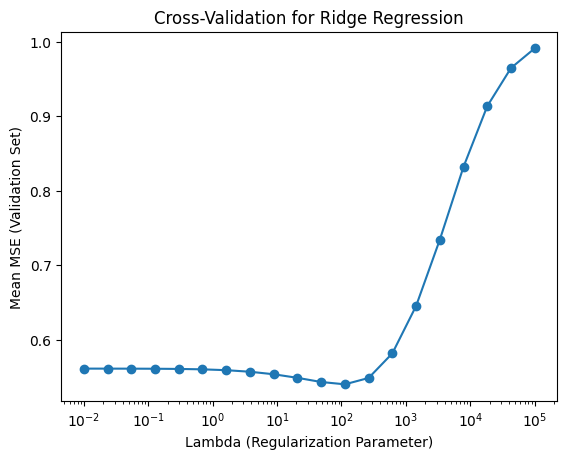

In [8]:
from sklearn.model_selection import train_test_split

N, K, T = neural_train.shape
X = neural_train_smoothed
V = hand_train

# Reshape into trial-based vectors
X_flat = X.reshape(N, K * T)  # N x (K*T)
V_flat = V.reshape(2, K * T)  # 2 x (K*T)

# Split trials into train (60%), validation (20%), and test (20%) sets
trial_indices = np.arange(K)
train_idx, temp_idx = train_test_split(trial_indices, test_size=0.4, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

X_train = X[:, train_idx, :].reshape(N, -1)  
V_train = V[:, train_idx, :].reshape(2, -1)
X_val = X[:, val_idx, :].reshape(N, -1)     
V_val = V[:, val_idx, :].reshape(2, -1)    
X_test = X[:, test_idx, :].reshape(N, -1)    
V_test = V[:, test_idx, :].reshape(2, -1) 

# Candidate set of lamda values
lambda_values = np.logspace(-2, 5, 20)
val_mse = []

# Train on training set and evaluate on validation set
for lamda in lambda_values:
    W_star = ridge_regression_decoder(V_train, X_train, lamda)
    V_val_pred = W_star @ X_val
    mse = mean_squared_error(V_val.flatten(), V_val_pred.flatten())
    val_mse.append(mse)

# Select the best lambda
optimal_lambda = lambda_values[np.argmin(val_mse)]
print(f"Optimal lambda: {optimal_lambda}")

# Train final model on combined train + validation set, using the optimal lambda we
X_combined = np.hstack((X_train, X_val))
V_combined = np.hstack((V_train, V_val))
W_final = ridge_regression_decoder(V_combined, X_combined, optimal_lambda)

# Evaluate on test set
V_test_pred = W_final @ X_test
test_mse = mean_squared_error(V_test.flatten(), V_test_pred.flatten())
print(f"Test MSE: {test_mse}")

# Check for overfitting
print(f"Validation MSE with optimal lambda: {min(val_mse)}")

# Plot results
import matplotlib.pyplot as plt
plt.plot(lambda_values, val_mse, marker='o')
plt.xscale('log')
plt.xlabel("Lambda (Regularization Parameter)")
plt.ylabel("Mean MSE (Validation Set)")
plt.title("Cross-Validation for Ridge Regression")
plt.savefig('CrossValidation')
plt.show()


#### Step 3 - Look at Quality of Predictions

<>:59: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\s'
C:\Users\oconn\AppData\Local\Temp\ipykernel_25144\1058288267.py:59: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("Window Length $\sigma$ (ms)")


Optimal sigma: 1.15 (57.49999999999999 ms)
Test MSE: 0.5161001675726498
Validation MSE with optimal sigma: 0.524904543018728


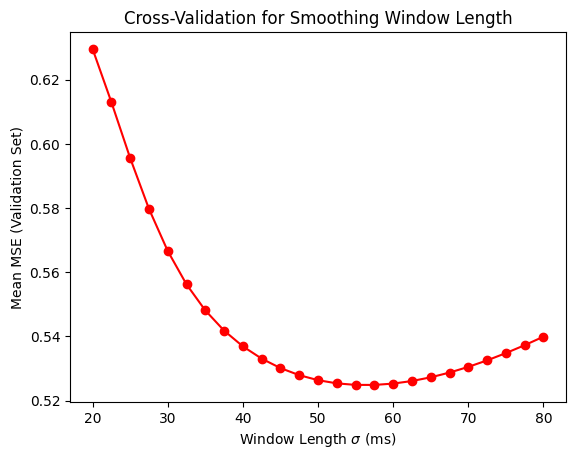

In [9]:
N, K, T = neural_train.shape
X = neural_train
V = hand_train

X_flat = X.reshape(N, K * T)  # N x (K*T)
V_flat = V.reshape(2, K * T)  # 2 x (K*T)

# Split trials into train (60%), validation (20%), and test (20%) sets
trial_indices = np.arange(K)
train_idx, temp_idx = train_test_split(trial_indices, test_size=0.4, random_state=39)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=39)

X_train = X[:, train_idx, :]  
V_train = V[:, train_idx, :].reshape(2, -1)
X_val = X[:, val_idx, :] 
V_val = V[:, val_idx, :].reshape(2, -1)    
X_test = X[:, test_idx, :]   
V_test = V[:, test_idx, :].reshape(2, -1) 

# Candidate set of lamda values
sigmas = np.arange(0.4, 1.6, 0.05)
val_mse = []


# Train on training set and evaluate on validation set
for sigma in sigmas:
    X = gaussian_filter1d(X_train, sigma, axis=-1)
    X_flat = X.reshape(N, X.shape[1]*X.shape[2])
    
    W_star = ridge_regression_decoder(V_train, X_flat, optimal_lambda)
    X_val_smoothed = gaussian_filter1d(X_val, sigma, axis=-1)
    X_val_smoothed_flat = X_val_smoothed.reshape(N, X_val_smoothed.shape[1]*X_val_smoothed.shape[2])
    V_val_pred = W_star @ X_val_smoothed_flat
    mse = mean_squared_error(V_val.flatten(), V_val_pred.flatten())
    val_mse.append(mse)

# Select the best lambda
optimal_sigma = sigmas[np.argmin(val_mse)]
print(f"Optimal sigma: {optimal_sigma} ({optimal_sigma*50} ms)")

X_combined = np.hstack((X_train, X_val))
X_combined = gaussian_filter1d(X_combined, optimal_sigma, axis=-1)
X_combined = X_combined.reshape(N, X_combined.shape[1]*X_combined.shape[2])
V_combined = np.hstack((V_train, V_val))
W_final = ridge_regression_decoder(V_combined, X_combined, optimal_lambda)

# Evaluate on test set
X_test = gaussian_filter1d(X_test, optimal_sigma, axis=-1)
X_test = X_test.reshape(N, X_test.shape[1]*X_test.shape[2])
V_test_pred = W_final @ X_test
test_mse = mean_squared_error(V_test.flatten(), V_test_pred.flatten())
print(f"Test MSE: {test_mse}")

print(f"Validation MSE with optimal sigma: {min(val_mse)}")

# Plot results
import matplotlib.pyplot as plt
plt.plot(sigmas*50, val_mse, marker='o', color='red')
plt.xlabel("Window Length $\sigma$ (ms)")
plt.ylabel("Mean MSE (Validation Set)")
plt.title("Cross-Validation for Smoothing Window Length")
plt.savefig('CrossValidationSigma')
plt.show()

In [10]:
## make predictions on test data using optimal sigma
N, K, T = neural_test.shape

V = hand_train

t0 = time.time()

V_flat = V.reshape(2, V.shape[1]*V.shape[2]) 
neural_train_smoothed = gaussian_filter1d(neural_train, sigma=optimal_sigma, axis=-1)
neural_train_smoothed = neural_train_smoothed.reshape(N, neural_train_smoothed.shape[1]*neural_train_smoothed.shape[2])

W_star = ridge_regression_decoder(V_flat, neural_train_smoothed, optimal_lambda)

neural_test_smoothed = gaussian_filter1d(neural_test, sigma=optimal_sigma, axis=-1)
neural_test_smoothed = neural_test_smoothed.reshape(N, K*T)    
V_pred_test = np.dot(W_star, neural_test_smoothed)

V_pred_test = V_pred_test.reshape(2, K, T)

t1 = time.time()
total = t1-t0

np.save("v_pred1.npy", V_pred_test)

total

0.11351418495178223

- **Comment on the suitability of this simple decoding strategy for online (“on the fly”) decoding of movement in a BMI context (consider e.g. feasability, computational tractability, and accuracy). Can you think of a small modification to the above approach that would improve applicability to online decoding?** (bonus points for  implementing it!)

### Suitability:
##### Feasibility:

The Gaussian smoothing and linear decoding are computationally lightweight, making the approach feasible for real-time implementation in Brain-Machine Interface (BMI) systems. However, because the Gaussian filter is non-causal, there will be a delay of sigma/2 (30ms in our case) before we get the estimated velocties. This delay may not be feasible depending on the BMI application.  

##### Accuracy:

While simple, the strategy provides reasonable decoding performance, especially with well-tuned 
𝜎
σ and 
𝜆
λ.
##### Challenges:

- Temporal Lag: Smoothing introduces a lag, as past and future data points influence the smoothed value. This reduces the real-time responsiveness of the decoder.
- Noise Sensitivity: Ridge regression assumes a linear relationship, which may not fully capture the complex dynamics of neural activity and hand velocity.

#### 4 - Causal Filtering
In signal processing, a causal filter is a linear and time-invariant causal system. The word causal indicates that the filter output depends only on past and present inputs. A filter whose output also depends on future inputs is non-causal, whereas a filter whose output depends only on future inputs is anti-causal. Systems (including filters) that are realizable (i.e. that operate in real time) must be causal because such systems cannot act on a future input. In effect that means the output sample that best represents the input at time 
t, comes out slightly later. A common design practice for digital filters is to create a realizable filter by shortening and/or time-shifting a non-causal impulse response. If shortening is necessary, it is often accomplished as the product of the impulse-response with a window function.

##### How to Make the Filter Causal
To make the filter strictly causal:

Use a one-sided Gaussian filter that only considers current and past data points.
Truncate the Gaussian kernel to include only non-negative time points (i.e., remove contributions from the "future").

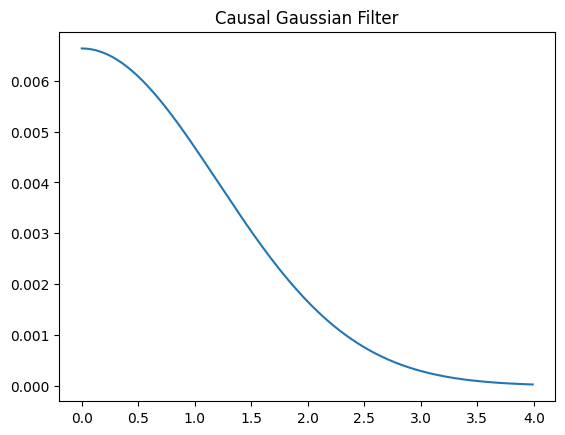

In [11]:
sigma = 1.2
filter_size = int(4 * sigma)                # the gaussian_1d function used from scipy by default truncates at 4 st. devs. so we will do the same
t = np.arange(0, filter_size, 0.01)         # only looking at half
gaussian_filter = np.exp(-t**2 / (2 * sigma**2)) 
gaussian_filter /= np.sum(gaussian_filter) 

plt.plot(t, gaussian_filter)
plt.title("Causal Gaussian Filter")
plt.show()


In [12]:
def causal_gaussian_smoothing(data, sigma):
    filter_size = int(4 * sigma) 
    t = np.arange(0, filter_size) 
    gaussian_filter = np.exp(-t**2 / (2 * sigma**2))
    gaussian_filter /= np.sum(gaussian_filter)

    smoothed_data = lfilter(gaussian_filter, 1, data, axis=-1)
    return smoothed_data

In [13]:
neural_test_smoothed = gaussian_filter1d(neural_test, sigma=optimal_sigma, axis=-1)
neural_test_causal_smoothed = causal_gaussian_smoothing(neural_test, sigma=optimal_sigma)

In [15]:
N, K, T = neural_train.shape
X = neural_train
V = hand_train

X_flat = X.reshape(N, K * T)  # N x (K*T)
V_flat = V.reshape(2, K * T)  # 2 x (K*T)

# Split trials into train (60%), validation (20%), and test (20%) sets
trial_indices = np.arange(K)
train_idx, temp_idx = train_test_split(trial_indices, test_size=0.4, random_state=39)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=39)

X_train = X[:, train_idx, :]  
V_train = V[:, train_idx, :].reshape(2, -1)
X_val = X[:, val_idx, :] 
V_val = V[:, val_idx, :].reshape(2, -1)    
X_test = X[:, test_idx, :]   
V_test = V[:, test_idx, :].reshape(2, -1) 

# Candidate set of lamda values
sigmas = np.arange(0.4, 1.6, 0.05)
val_mse = []


# Train on training set and evaluate on validation set
for sigma in sigmas:
    #X = gaussian_filter1d(X_train, sigma, axis=-1)
    X = causal_gaussian_smoothing(X_train, sigma)
    X_flat = X.reshape(N, X.shape[1]*X.shape[2])
    
    W_star = ridge_regression_decoder(V_train, X_flat, optimal_lambda)
    #X_val_smoothed = gaussian_filter1d(X_val, sigma, axis=-1)
    X_val_smoothed = causal_gaussian_smoothing(X_val, sigma)
    X_val_smoothed_flat = X_val_smoothed.reshape(N, X_val_smoothed.shape[1]*X_val_smoothed.shape[2])
    V_val_pred = W_star @ X_val_smoothed_flat
    mse = mean_squared_error(V_val.flatten(), V_val_pred.flatten())
    val_mse.append(mse)

# Select the best lambda
optimal_sigma = sigmas[np.argmin(val_mse)]
print(f"Optimal sigma: {optimal_sigma} ({optimal_sigma*50} ms)")

X_combined = np.hstack((X_train, X_val))
#X_combined = gaussian_filter1d(X_combined, optimal_sigma, axis=-1)
X_combined = causal_gaussian_smoothing(X_combined, optimal_sigma)
X_combined = X_combined.reshape(N, X_combined.shape[1]*X_combined.shape[2])
V_combined = np.hstack((V_train, V_val))
W_final = ridge_regression_decoder(V_combined, X_combined, optimal_lambda)

# Evaluate on test set
#X_test = gaussian_filter1d(X_test, optimal_sigma, axis=-1)
X_test = causal_gaussian_smoothing(X_test, optimal_sigma)
X_test = X_test.reshape(N, X_test.shape[1]*X_test.shape[2])
V_test_pred = W_final @ X_test
test_mse = mean_squared_error(V_test.flatten(), V_test_pred.flatten())
print(f"Test MSE: {test_mse}")

print(f"Validation MSE with optimal sigma: {min(val_mse)}")

Optimal sigma: 1.5999999999999996 (79.99999999999999 ms)
Test MSE: 0.5058324215415586
Validation MSE with optimal sigma: 0.5436936328539984


In [16]:
## make predictions on test data using optimal sigma
N, K, T = neural_test.shape

V = hand_train
V_flat = V.reshape(2, V.shape[1]*V.shape[2]) 
#neural_train_smoothed = gaussian_filter1d(neural_train, sigma=optimal_sigma, axis=-1)
neural_train_smoothed = causal_gaussian_smoothing(neural_train, optimal_sigma)
neural_train_smoothed = neural_train_smoothed.reshape(N, neural_train_smoothed.shape[1]*neural_train_smoothed.shape[2])

W_star = ridge_regression_decoder(V_flat, neural_train_smoothed, optimal_lambda)

#neural_test_smoothed = gaussian_filter1d(neural_test, sigma=optimal_sigma, axis=-1)
neural_test_smoothed = causal_gaussian_smoothing(neural_test, optimal_sigma)
neural_test_smoothed = neural_test_smoothed.reshape(N, K*T)    
V_pred_test = np.dot(W_star, neural_test_smoothed)

V_pred_test = V_pred_test.reshape(2, K, T)
np.save("v_pred1_causal_gaussian.npy", V_pred_test)

as expected, the first data point has a low R^2 because the causal Gaussian filter doesnt have any data to smooth it with yet

- The hand velocity data provided in `data["hand_train"]` had actually been shifted backward by 120ms relative to the neural data (and similarly for the test set, which was not given to you). **Can you speculate about why we did that**?

The hand velocity data in data["hand_train"] was shifted backward by 120ms relative to the neural data to account for neural processing delays and the time it takes for neural activity to translate into physical movement. This shift aligns the neural signals with the resulting hand movements more accurately, enabling better decoding of motor intention.

# 3. Kalman filter-based decoding

We now turn to a more sophisticated decoder based on a Kalman filter/smoother.

### 3.1 An autoregressive prior for hand kinematics

A 10-dimensional linear latent dynamical system (“LDS”; cf lecture notes) was pre-trained for you on the hand velocity data in the training set; specifically, we consider the following generative model:

$$
(1) \qquad z_{k, 0} \sim \mathcal{N}(\mu_0, \Sigma_0) \\ 
(2) \qquad z_{k, t+1} = A z_{k, t} + \epsilon_{k, t+1} \quad \text{with } \epsilon_{k, t+1} \sim \mathcal{N}(0, Q) \\
(3) \qquad v_{k, t} = C z_{k, t} + \eta_{k, t} \quad \text{with } \eta_{k, t} \sim \mathcal{N}(0, R)
$$

where $z_{k, t} \in \mathbb{R}^{10}$ is the latent state in time bin $t$ of trial $k$, and $v_{k, t} \in \mathbb{R}^2$ is the corresponding hand velocity. 

The parameters of this LDS can be found in the same `data` dictionary as above, with the following keys:
- "hand_KF_A" (`10 × 10`): state matrix $A$
- "hand_KF_C" (`2 × 10`): output matrix $C$
- "hand_KF_mu0" (`10 × 1`): initial prior mean $\mu_0$
- "hand_KF_Sigma0" (`10 × 10`): initial prior covariance $\Sigma_0$
- "hand_KF_Q" (`10 × 10`): process noise covariance matrix $Q$
- "hand_KF_R" (`2 × 2`): observation noise covariance matrix $R$

<u>Write your own Kalman smoother implementation and use it to compute the mean $\hat{z}_{k, 1:T}$ of the smoothing distribution $p(z_{k, t} | v_{k, 1:T})$, for each trial $k$ in the training set.</u>


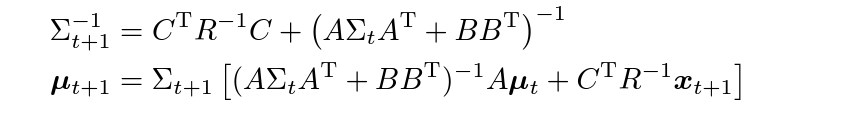

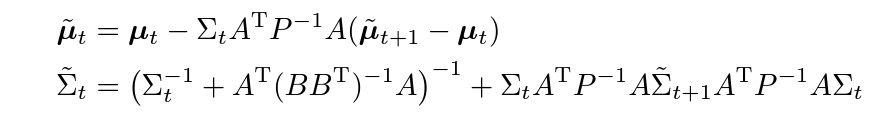

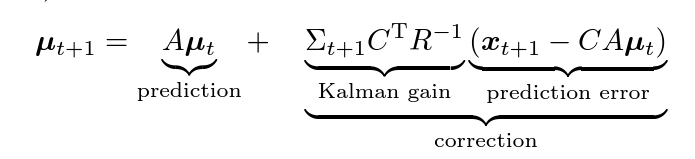

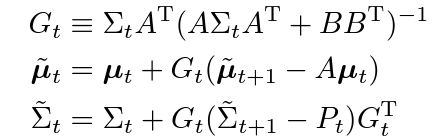

In [19]:
from numpy.linalg import inv

def kalman_filter1(A, C, Q, R, mu0, Sigma0, y):
    _, time_horizon = y.shape
    latent_dim = mu0.shape[0]

    constant_matrix = C.T @ inv(R) @ C      # constant w.r.t time
    
    # Arrays for holding the filtered results
    filtered_mews = np.zeros((latent_dim, time_horizon))
    filtered_sigmas = np.zeros((latent_dim, latent_dim, time_horizon))

    for t in range(time_horizon):
        if t == 0:
            sigma_t = Sigma0
            mew_t = mu0
        else:
            P = inv(A @ sigma_t @ A.T + Q) 
            sigma_t = inv(constant_matrix + P)
            
            kalman_gain = sigma_t @ C.T @ inv(R)
            prediction_error = y[:, t] - (C @ A @ mew_t).squeeze()
            
            mu_pred_no_gain = A @ mew_t
            mew_t = mu_pred_no_gain + kalman_gain @ prediction_error[:, None]
        
        # append to the results
        filtered_sigmas[:, :, t] = sigma_t
        filtered_mews[:, t] = mew_t.squeeze()
    
    return filtered_mews, filtered_sigmas

def kalman_smoother(A, C, Q, R, mu0, Sigma0, y):
    _, time_horizon = y.shape
    latent_dim = mu0.shape[0]

    filtered_mews, filtered_sigmas = kalman_filter1(A, C, Q, R, mu0, Sigma0, y)
    
    smoothed_mews = np.zeros((latent_dim, time_horizon))
    smoothed_sigmas = np.zeros((latent_dim, latent_dim, time_horizon))
    
    # the first smoothed mew and sigma are just the final entry in the filtered mews and sigmas
    mew_t = filtered_mews[:, -1]
    sigma_t= filtered_sigmas[:,:,-1]
    
    for t in range(time_horizon):
        j = time_horizon-t-1
        
        G = filtered_sigmas[:, :, j] @ A.T @ inv(A @ filtered_sigmas[:, :, j] @ A.T + Q)
        P = inv(A @ filtered_sigmas[:, :, j] @ A.T + Q)
        
        mew_t = mew_t.squeeze()
        mew_t = filtered_mews[:, j] + G @ (mew_t - A @ filtered_mews[:, j])
        sigma_t = filtered_sigmas[:, :, j] + G @ (sigma_t - P) @ G.T
        
        smoothed_mews[:, j] = mew_t
        smoothed_sigmas[:, :, j] = sigma_t
    
    return smoothed_mews

In [20]:
mu0 = data["hand_KF_mu0"]
Sigma0 = data["hand_KF_Sigma0"]
A = data["hand_KF_A"]
C = data["hand_KF_C"]
Q = data["hand_KF_Q"]
R = data["hand_KF_R"]

Z_smooth = np.zeros((10, 400, 16))

for k in range(400):
    observations = hand_train[:, k, :]
    s_m = kalman_smoother(A, C, Q, R, mu0, Sigma0, observations)

    Z_smooth[:, k, :] = s_m

Z_smooth.shape

(10, 400, 16)

### 3.2 Building an LDS model of neural data using supervised learning

Conceptually, the latents $z_{k, 1:T}$ introduced above contain signals related to the velocity of the hand, its acceleration, and potentially higher-order derivatives too — all signals which we have good reasons to suspect that neural activity in M1 is strongly related to. Eqs (1) and (2) above provide a good autoregressive prior model for the temporal dynamics of these signals, and you are now going to use this prior in a generative LDS model of _neural data_, substituting the hand-related likelihood (Eq 3) with a neural likelihood:

$$
(4) \qquad x_{k, t} = D z_{k, t} + \xi_{k, t} \quad \text{with } \xi_{k, t} \sim \mathcal{N}(0, S)
$$

where $x_{k, t}$ denotes neural spike counts in the $t^\text{th}$ time bin of trial $k$.

The combination of Eqs (1), (2) and (4) forms an LDS model which you will be able to invert using Kalman filtering to obtain a filtered posterior $p(z_{k', t} | x_{k', 0:t})$ for any test trial $k'$. From there, you will use Eq. (3) to obtain a filtered predictive distribution for the hand velocity in each test trial, $p(v_{k', t} | x_{k', 0:t})$.

- <u>Begin by centering the neural data (both training and testing sets) by removing, for each neuron, its mean activity across both trials and time in the training set.</u>
- <u>Fit the likelihood parameters $D$ and $S$ through supervised learning, by maximizing the joint log-likelihood $\log p(\hat{z}_{k, 1:T}, x_{k, 1:T})$ averaged over all trials in the training set, where $\hat{z}_{k,1:T}$ is the posterior mean you obtained in Section 3.1.</u>
To do this, write down the average joint log likelihood and **show that it is maximized by the following parameter settings**:
    - $ \displaystyle D^\star = \left(\sum_{k, t} x_{k, t} \hat{z}_{k, t}^\top \right) \left( \sum_{k, t} \hat{z}_{k, t} \hat{z}_{k, t}^\top \right)^{-1} $
    - $ \displaystyle S^\star = \frac{1}{KT} \left( \sum_{k, t} x_{k, t} x_{k, t}^\top - D^\star \sum_{k, t} \hat{z}_{k, t} x_{k, t}^\top \right) $ where $K$ is the number of trials in the training set. **Include your derivations in your report.**

In [21]:
# center the neural data, X is the centered neural data
mean_over_time_and_conditions = np.mean(neural_train, axis=(1, 2))              # mean taken over time and trials in TRAINING SET
X = neural_train - mean_over_time_and_conditions[:, np.newaxis, np.newaxis]

# center test nerual data aswell, using mean of training
X_test = neural_test - mean_over_time_and_conditions[:, np.newaxis, np.newaxis]

In [22]:
def D_star(X, Z):
    N, K, _ = X.shape
    M = Z.shape[0]                   # latent dimension
    
    matrix1 = np.zeros((N, M))
    matrix2 = np.zeros((M, M))

    for k in range(K):
        x = X[:, k, :]
        z = Z[:, k, :]
        matrix1 = matrix1 + (x @ z.T)
        matrix2 = matrix2 + (z @ z.T)
    return matrix1 @ np.linalg.inv(matrix2)

def S_star(X, Z):
    N, K, T = X.shape
    M = Z.shape[0]   
    
    matrix1 = np.zeros((N, N))
    matrix2 = np.zeros((M, N))

    for k in range(K):
        x = X[:, k, :]
        z = Z[:, k, :]
        matrix1 = matrix1 + (x @ x.T)
        matrix2 = matrix2 + (z @ x.T)
    
    D = D_star(X, Z)
    term = matrix1 - (D @ matrix2)
    return (1/(K*T)) * term

In [23]:
D = D_star(X, Z_smooth)
S = S_star(X, Z_smooth)

### 3.3 Using Kalman filtering to predict the hand velocity

- Based on the model obtained in Section 3.2, <u>write your own Kalman filter implementation and compute the filtered posterior $p(z_{k', t} | x_{k', 0:t}) $ for each trial $k'$ in the test set.</u> What we are really interested in is the mean $\bar{z}_{k', t}$ of this filtered posterior, as our best prediction of the momentary hand velocity $v_{k', t}$ is then given by $\hat{v}_{k', t} = C \bar{z}_{k', t}$.
- <u>Submit your predictions to http://4G10.cbl-cambridge.org (note: http, not https) in the same format as described in Section 2. Please select "Kalman filtering" in the dropdown list. Once again, you will receive immediate feedback in the form of an $R^2$ coefficient.</u> **Include this result in your report, and discuss; in particular, why do you think these predictions are much better than those of Section 2?**
- As in Section 2, **comment on the suitability of this more sophisticated decoding strategy for online decoding of movement in a BCI context**.
- Finally, **what approach(es) would you suggest to improve decoding performance even further? Include a discussion of the tradeoffs that would arise with these alternative approaches.** (max 1 page in your report)

In [24]:
N, K, T = X_test.shape
V_predictions = np.zeros((2, K, T))


t0 = time.time()

for k in range(K):
    observations = X_test[:, k, :]
    f_m, f_s = kalman_filter1(A, D, Q, S, mu0, Sigma0, observations)
    v_hat = C @ f_m
    V_predictions[:, k, :] = v_hat

t1 = time.time()

total = t1-t0
total

15.557679414749146

In [76]:
np.save("v_pred2.npy", V_predictions)

# Writing up


Please write up your findings in a report to be submitted on Moodle in PDF format, and **include all your code in the Appendix**. Please clearly include your candidate number, NOT your name, on the front page. Your report should address all the questions raised in this notebook, be structured around the Sections of this notebook, and **be a maximum of five A4 pages** excluding any Appendix (minimum font size 11pt, minimum margins 1.5cm on each side).

You are very much encouraged to think of data/results visualisations to best support the exposition of your results. You are also encouraged to report on any specific problems/difficulties that arose in your implementation of the various algorithms, and how you addressed those.